## Implementation of RFUAV-net
efficient CNN method - 1D convolution

In [76]:
import os
import numpy as np
from sklearn.model_selection import KFold
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
from helper_functions import *
from loading_functions import *

import time

In [2]:
## Import data -  Drone RF
main_folder = '/home/kzhou/Data/DroneRF/'
t_seg = 0.25 #ms
Xs_arr, ys_arr, y4s_arr, y10s_arr = load_dronerf_raw(main_folder, t_seg)

diff 5 file name: 00000L_13.csv


### Apply Model

In [3]:
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torch
import torchvision.models as models

In [4]:
dataset = DroneData(Xs_arr, ys_arr)

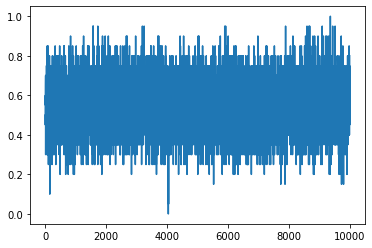

In [5]:
plt.plot(dataset.__getitem__(40)[0][0][1].numpy())

In [6]:
class RFUAVNet(nn.Module):
    #  Determine what layers and their order in CNN object 
    def __init__(self, num_classes):
        super(RFUAVNet, self).__init__()
        self.num_classes = num_classes

        self.dense = nn.Linear(320, num_classes)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.smax = nn.Softmax(dim=0)
        
        # for r unit
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=64, kernel_size=5, stride=5)
        self.norm1 = nn.BatchNorm1d(num_features=64)
        self.elu1 = nn.ELU(alpha=1.0, inplace=False)
        
        # setup for components of the gunit
        self.groupconvlist = []
        self.norm2list = []
        self.elu2list = []
        for i in range(4):
            self.groupconvlist.append( nn.Conv1d( 
                  in_channels=64,
                  out_channels=64,
                  kernel_size=3,
                  stride = 2,
                  groups=8,
    #               bias=False,
                  dtype=torch.float32
                ))
            self.norm2list.append(nn.BatchNorm1d(num_features=64))
            self.elu2list.append(nn.ELU(alpha=1.0, inplace=False))
        self.groupconv = nn.ModuleList(self.groupconvlist)
        self.norm2 = nn.ModuleList(self.norm2list)
        self.elu2 = nn.ModuleList(self.elu2list)
        
        # multi-gap implementation
        self.avgpool1000 = nn.AvgPool1d(kernel_size=1000)
        self.avgpool500 = nn.AvgPool1d(kernel_size=500)
        self.avgpool250 = nn.AvgPool1d(kernel_size=250)
        self.avgpool125 = nn.AvgPool1d(kernel_size=125)
    
    # Progresses data across layers    
    def forward(self, x):
        # runit first
        x1 = self.runit(x)
# #         print('x1 shape', x1.shape)
        xg1 = self.gunit(F.pad(x1, (1,0)), 0) 
        x2 = self.pool(x1)
        x3 = xg1+x2
        
#         print('x3 shape', x3.shape)
        xg2 = self.gunit(F.pad(x3, (1,0)), 1)
        x4 = self.pool(x3)
        x5 = xg2+x4
        
#         print('x5 shape', x5.shape)
        xg3 = self.gunit(F.pad(x5, (1,0)), 2)
        x6 = self.pool(x5)
        x7 = x6+xg3
        
        xg4 = self.gunit(F.pad(x7, (1,0)), 3)
        x8 = self.pool(x7)
        x_togap = x8+xg4
        
#         print('xg1 shape:', xg1.shape)
        
#         # CONTINUE from the gap and multi-gap implementation
        f_gap_1 = self.avgpool1000(xg1)
#         print('gap 1 shape', f_gap_1.shape)
        f_gap_2 = self.avgpool500(xg2)
#         print('gap 2 shape', f_gap_2.shape)
        f_gap_3 = self.avgpool250(xg3)
#         print('gap 3 shape', f_gap_3.shape)
        f_gap_4 = self.avgpool125(xg4)
#         print('gap 4 shape', f_gap_4.shape)
        
        f_multigap = torch.cat((f_gap_1,f_gap_2, f_gap_3, f_gap_4), 1)
#         print('f_multigap shape:',f_multigap.shape)
        
#         print('shape of x to gap', x_togap.shape)
        f_gap_add = self.avgpool125(x_togap)
    
        f_final = torch.cat((f_multigap, f_gap_add),1)
#         print('avg pool:', self.avgpool1(xg3).shape)
        f_flat = f_final.flatten(start_dim=1)
    
        f_fc = self.dense(f_flat)
        out = self.smax(f_fc)
        # fc_layer
        
        return out
    
    def runit(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.elu1(x)
        return x
        
    def gunit(self, x, n):
        # group convolution layer 8 by 8
        # norm
        # elu
        # n indicates which gunit
        x = self.groupconv[n](x) 
        x = self.norm2[n](x)
        x = self.elu2[n](x)
        return x

In [161]:
## Test network
# input1 = dataset.__getitem__(40)[0]
# input1= input1.type(torch.float)
# input = input.reshape(1, 2, 10000)
input1 = torch.rand(1, 2, 10000)

print(input1.shape)

# input_1d = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype = torch.float)

net = RFUAVNet(2)
out = net(input1)

print(out.shape)
print(out)

torch.Size([1, 2, 10000])
torch.Size([1, 2])
tensor([[1., 1.]], grad_fn=<SoftmaxBackward0>)


In [112]:
# Network Hyperparameters

batch_size = 128 # 128
num_classes = 2
learning_rate = 0.01
num_epochs = 3 # 0
momentum = 0.95
l2reg = 1e-4


In [113]:
# Set up data and parameters

## Set up Data
train_split_percentage = 0.9
split_lengths = [int(train_split_percentage*len(dataset)), len(dataset)-int(train_split_percentage*len(dataset))]
train_set, test_set = torch.utils.data.random_split(dataset, split_lengths)

train_loader = torch.utils.data.DataLoader(dataset = train_set,
                                           batch_size = batch_size,
                                           shuffle = True)


test_loader = torch.utils.data.DataLoader(dataset = test_set,
                                           batch_size = batch_size,
                                           shuffle = True)


## Set up Model


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = RFUAVNet(num_classes)
model = model.to(device)

# Set Loss function with criterion
criterion = nn.CrossEntropyLoss()

# Set optimizer with optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=l2reg, momentum = momentum)  

total_step = len(train_loader)

In [114]:
# Training
# We use the pre-defined number of epochs to determine how many iterations to train the network on
for epoch in range(num_epochs):
    #Load in the data in batches using the train_loader object
    for i, (inputs, labels) in enumerate(train_loader): 
        inputs = inputs.float()
        inputs = torch.squeeze(inputs, 1)
        labels = labels.type(torch.long)

        # Move tensors to the configured device
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i%50 == 49:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))


Epoch [1/3], Loss: 0.6932
Epoch [1/3], Loss: 0.6932
Epoch [1/3], Loss: 0.6932
Epoch [1/3], Loss: 0.6930
Epoch [1/3], Loss: 0.6931
Epoch [1/3], Loss: 0.6931
Epoch [1/3], Loss: 0.6930
Epoch [1/3], Loss: 0.6931
Epoch [1/3], Loss: 0.6931
Epoch [1/3], Loss: 0.6931
Epoch [1/3], Loss: 0.6930
Epoch [1/3], Loss: 0.6932
Epoch [1/3], Loss: 0.6930
Epoch [1/3], Loss: 0.6931
Epoch [1/3], Loss: 0.6930
Epoch [1/3], Loss: 0.6929
Epoch [1/3], Loss: 0.6928
Epoch [1/3], Loss: 0.6931
Epoch [1/3], Loss: 0.6929
Epoch [1/3], Loss: 0.6927
Epoch [1/3], Loss: 0.6927
Epoch [1/3], Loss: 0.6929
Epoch [1/3], Loss: 0.6923
Epoch [1/3], Loss: 0.6923
Epoch [1/3], Loss: 0.6928
Epoch [1/3], Loss: 0.6928
Epoch [1/3], Loss: 0.6924
Epoch [1/3], Loss: 0.6924
Epoch [1/3], Loss: 0.6923
Epoch [1/3], Loss: 0.6925
Epoch [1/3], Loss: 0.6920
Epoch [2/3], Loss: 0.6872
Epoch [2/3], Loss: 0.6916
Epoch [2/3], Loss: 0.6907
Epoch [2/3], Loss: 0.6920
Epoch [2/3], Loss: 0.6928
Epoch [2/3], Loss: 0.6884
Epoch [2/3], Loss: 0.6920
Epoch [2/3],

In [86]:
## Check accuracy
with torch.no_grad():
    correct = 0
    total = 0
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        inputs = inputs.float()
        inputs = torch.squeeze(inputs, 1)
        
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
#         print(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    print('Accuracy of the network on the {} train images: {} %'.format(total, 100 * correct / total))


Accuracy of the network on the 22600 train images: 88.24778761061947 %


In [87]:
get_n_params(model)

8386

## K-fold CV

In [115]:
# Configuration options
k_folds = 2

# For fold results
results = {}
runtimes = {}

# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)

# Start print
print('--------------------------------')

# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(
                      dataset, 
                      batch_size=batch_size, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=batch_size, sampler=test_subsampler)

    # Init the neural network
    network = RFUAVNet(num_classes)
    network = network.to(device)
#     network.apply(reset_weights)

    criterion = nn.CrossEntropyLoss()

    # Initialize optimizer
    optimizer = torch.optim.Adam(network.parameters(), lr=1e-4)
#     optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate, weight_decay=l2reg, momentum = momentum)  

    # Run the training loop for defined number of epochs
    for epoch in range(0, num_epochs):
        # Print epoch
        print(f'Starting epoch {epoch+1}')

        # Set current loss value
        current_loss = 0.0

        # Iterate over the DataLoader for training data
        for i, data in enumerate(trainloader):
            # Get inputs
            inputs, targets = data
            inputs = inputs.float()
            inputs = torch.squeeze(inputs, 1)
            targets= targets.type(torch.long)
                        
            # Move tensors to configured device
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # Perform forward pass
            outputs = network(inputs)
            
            # Compute loss            
            loss = criterion(outputs, targets)

            # Zero the gradients
            optimizer.zero_grad()

            # Perform backward pass
            loss.backward()

            # Perform optimization
            optimizer.step()

            # Print statistics
            current_loss += loss.item()
            if i % 50 == 49:
                print('    Loss after mini-batch %5d: %.5f' %
                      (i + 1, current_loss / 50))
                current_loss = 0.0
#         print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

    # Process is complete.
#     print('Training process has finished. Saving trained model.')

    # Print about testing
    print('Starting testing')

    # Saving the model
#     save_path = f'./model-fold-{fold}.pth'
#     torch.save(network.state_dict(), save_path)

    # Evaluation for this fold
    correct, total = 0, 0
    with torch.no_grad():
        starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
        runtimes_all = np.zeros(len(testloader), dtype=float)
        # Iterate over the test data and generate predictions
        for i, data in enumerate(testloader, 0):
            # Get inputs
            inputs, targets = data
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Generate outputs
            n_instances = len(inputs)
            runtimes = np.zeros(n_instances, dtype=float)
            ys = torch.empty(n_instances)
            ys = ys.to(device)

            for i in range(n_instances):
                instance = inputs[i]
                instance = instance.float()
                start = time.time()
                starter.record()
                yi = network(instance)
                _,pred = torch.max(yi,1)
                ender.record()
                
                torch.cuda.synchronize()
                curr_time = starter.elapsed_time(ender) #miliseconds

                runtimes[i] = curr_time*1e-3
                ys[i] = pred


            # Set total and correct
            total += targets.size(0)
            correct += (ys == targets).sum().item()
            mean_runtime = np.mean(runtimes)

            # Print accuracy
            print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
    print('--------------------------------')
    results[fold] = 100.0 * (correct / total)
    runtimes_all[fold] = mean_runtime

# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')
sum = 0.0
for key, value in results.items():
    print(f'Fold {key}: {value} %')
    sum += value
print(f'Average Accuracy: {sum/len(results.items())} %')
print(f'Average Runtime: {sum/len(runtimes_all.items())} %')

--------------------------------
FOLD 0
--------------------------------
Starting epoch 1
Loss after mini-batch    50: 0.69303
Loss after mini-batch   100: 0.69277
Loss after mini-batch   150: 0.69237
Loss after mini-batch   200: 0.69212
Loss after mini-batch   250: 0.69187
Loss after mini-batch   300: 0.69161
Loss after mini-batch   350: 0.69136
Loss after mini-batch   400: 0.69077
Loss after mini-batch   450: 0.69015
Loss after mini-batch   500: 0.68937
Loss after mini-batch   550: 0.68865
Loss after mini-batch   600: 0.68786
Loss after mini-batch   650: 0.68749
Loss after mini-batch   700: 0.68693
Loss after mini-batch   750: 0.68665
Loss after mini-batch   800: 0.68646
Loss after mini-batch   850: 0.68635
Starting epoch 2
Loss after mini-batch    50: 0.68617
Loss after mini-batch   100: 0.68610
Loss after mini-batch   150: 0.68598
Loss after mini-batch   200: 0.68593
Loss after mini-batch   250: 0.68599
Loss after mini-batch   300: 0.68598
Loss after mini-batch   350: 0.68594
Loss 

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper___slow_conv2d_forward)

In [137]:

starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)

inputs = torch.squeeze(inputs,1)
inputs = inputs.to(device)
inputs = inputs.float()

starter.record()
outtest = network(inputs)

ender.record()
# WAIT FOR GPU SYNC
torch.cuda.synchronize()
curr_time = starter.elapsed_time(ender) #miliseconds
# timings[rep] = curr_time
        
        


In [148]:
runtimes[i] = curr_time*1e-3
runtimes

array([0.00120854, 0.00115561, 0.00112224, 0.00117898, 0.00116229,
       0.00115919, 0.00115228, 0.00117373, 0.00114274, 0.00116444,
       0.0011754 , 0.00115967, 0.00116277, 0.00115824, 0.00117183,
       0.00115681, 0.00115895, 0.00117326, 0.00114083, 0.0011189 ,
       0.00114775, 0.00115991, 0.00112081, 0.00111628, 0.00117564,
       0.00113463, 0.00112319, 0.00115609, 0.001158  , 0.00111437,
       0.00111818, 0.00118017, 0.00113297, 0.00111723, 0.00113511,
       0.00111723, 0.00111938, 0.00111723, 0.00113392, 0.00112081,
       0.00112319, 0.00116372, 0.00111938, 0.00111842, 0.00112844,
       0.00111699, 0.00111961, 0.00112081, 0.00117087, 0.00114298,
       0.00111985, 0.00112748, 0.00112724, 0.00111508, 0.00111985,
       0.00117445, 0.00114036, 0.00111866, 0.00112987, 0.00111723,
       0.00112104, 0.00111389, 0.00113177, 0.00111771, 0.001122  ,
       0.00112605, 0.00112152, 0.00113869, 0.00116134, 0.00117326,
       0.00113177, 0.00114965, 0.00117469, 0.00115919, 0.00116

In [145]:
_,pred = torch.max(outtest,1)
pred == targets

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True, False,
        False,  True,  True, False,  True,  True, False, False,  True,  True,
         True,  True, False,  True,  True,  True,  True,  True, False,  True,
         True,  True,  True,  True,  True,  True,  True, False,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
        False,  True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True, False,  True],

In [181]:
# prediction on one instance to measure inference time

testdata =next(iter(testloader))
batchdata, batchtarget  = testdata
# print(batchdata.shape)

i = 15

instance = batchdata[i]

# prediction on an instance
instance = instance.float()
onepred = network(instance.to(device))
print(onepred)

# prediction on a batch
batchdata = batchdata.to(device)
batchdata = batchdata.float()
batchdata = torch.squeeze(batchdata,1)
batchpred = network(batchdata)

print(batchpred[i])

print (onepred == batchpred[i])

tensor([[1., 1.]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([7.5869e-08, 5.9106e-03], device='cuda:0', grad_fn=<SelectBackward0>)
tensor([[False, False]], device='cuda:0')
